<h1> <font color=steelblue>Constraining River Discharge Estimation Priors Using Reach-Scale Geomorphology</font></h1>
<br>
    Craig Brinkerhoff <br>
    Colin Gleason <br>
    Peirong Lin <br>
    Konstantinos Andreadis <br>
    Mark Hagemann

<h3><font color=darkcyan> What? </font></h3>
<p>
BAM uses Bayesian inference to estimate river discharge and thus relies on prior distributions of certain variables. Also to be devolped for SADS and MetroMan
</p> <br>
<h5>
    So, can we produce better discharge estimates by constraining these priors by river type?
    <br><br>
    AND, how does our classification of American river geomorphology vary as a direct function of the hydrographic network used? i.e. are results fundamentally different if using coarser hydrographic networks, wherein many smaller rivers are functionally non-existent?
</h5>

<h3><font color=darkcyan> MERIT Hydro </font></h3>

<p> This work is performed on a dataset of USGS field mesurements of channel hydraulics originally collected by Barber and Gleason (2018) joined to NHD, resulting in an expanded version of the dataset used in Brinkerhoff, et al. (2019)
    <br><br>
    Stream Order <br>
    Slope <br>
    Stream Drop <br>
    Maximum Grain Size Entrained (Henderson, 1966) <br>
    Shear Stress <br>
    Froude Number <br>
    Drainage Area <br>
    Unit Stream Power <br>
    Channel Shape <br>
    Channel Width <br>
    Channel Depth <br>
    Channel Velocity <br>
    Sinuosity <br>
    Bankfull Shape <br>
    Bankfull Width <br>
    Bankfull Depth <br>
    Bankfull Velocity <br>
    # rivers draining into reach ('topology')<br>
    <br><br>It must be stressed that these joined variables exist at the reach-scale, while the field measurements exist at the cross-section scale. Also, these results are only reflective of the hydrology/geomorphology of river reaches measured by the USGS, generally at streamagauges. IMPORTANT.</p>

<h3><font color=darkcyan> USGS NHD 2.1 </font></h3>

<p> This work is performed on a dataset of USGS field mesurements of channel hydraulics originally collected by Barber and Gleason (2018) joined to NHD, resulting in an expanded version of the dataset used in Brinkerhoff, et al. (2019, in review)
    <br><br>
    Stream Order <br>
    Slope <br>
    Distance Downstream <br>
    Maximum Grain Size Entrained (Henderson, 1966) <br>
    Shear Stress <br>
    Froude Number <br>
    Drainage Area <br>
    Unit Stream Power <br>
    Channel Shape <br>
    Channel Width <br>
    Channel Depth <br>
    Channel Velocity <br>
    Bankfull Shape <br>
    Bankfull Width <br>
    Bankfull Depth <br>
    Bankfull Velocity <br>
    Reach Type (i.e. perennial, intermittent, lake/wetland/reservoir, canal, or connector).<br>
    Sinuosity (eventually)
    <br><br>It must be stressed that these joined variables exist at the reach-scale, while the field measurements exist at the cross-section scale. Also, these results are only reflective of the hydrology/geomorphology of river reaches measured by the USGS, generally at streamagauges. IMPORTANT.</p>

<h3><font color=darkcyan> Necessary preprocessing on NHD </font></h3>
<p> NHD for some reason has assigned many main stem or close-to-main stem reaches as artifical paths and not rivers.  Artifical paths are only supposed to be for throughflow lines in lakes/wetlands/reservoirs.
<br><br>
So, I identified reaches classed as 'ArtificalPath' that had no corresponding waterbodyID in the lakes dataset, assumed main stem reaches are perrenial, and reclassified those reaches as perrenial rivers.
<br><br> Canals and NHD's 'connectors' are listed as Artifical Channels.  'Connectors' are reaches the NHD had to add to make the network continuous in some places (i.e. trhough dams)
<br><br>
I am using the NHD's defintion of river intermittncy.  It's unclear how they designate perrenial/intermittent/ephemeral (no ephemeral reaches had measurements on them)
</p>

<h4> <font color=darkolivegreen> Initial Data Preperation, Wrangling, and Cleaning </font> </h4>

In [1]:
import pandas as pd
import os
import numpy as np
import scipy.stats.mstats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from pandas.tools.plotting import parallel_coordinates
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from ast import literal_eval

#set working directory here
os.chdir("C:\\Users\\craig\\Box Sync\\Ongoing Projects\\geomorph_class\\")

#load in barber dataset
Hydroshortened = pd.read_csv('Barber_rivers.csv', low_memory=False, encoding='latin-1')

#MERIT Hydro
#MERITshortened = pd.read_table('MERIT_Hydro_reaches2.txt', sep=',') #all reaches and atributes
#MERITshortened['COMID'] = MERITshortened['COMID'].astype('int32')
#MERITshortened = MERITshortened[MERITshortened['stationid'].str.startswith('USGS')]
#MERITshortened['stationid'] = MERITshortened['stationid'].str[5:]
#MERITshortened['stationid'] = pd.to_numeric(MERITshortened['stationid'])

#MERITshortened = pd.merge(MERITshortened, Hydroshortened, left_on='stationid', right_on='site_no') #merge on usgs gauge ID

#NHD 2.1 flowlines (with USGS gauges on them) and lakes
med_NHD = pd.read_csv('C:\\Users\\craig\\Box Sync\\Published\\hydraulic_geometry_project_2019\\working\\NHD_med_res.csv', low_memory=False, encoding='latin-1')
med_NHD_lakes = pd.read_csv('med_NHD_lakes.csv', low_memory=False, encoding='latin-1')

#NHD sinuosity from  Wieczorek, M.E., Jackson, S.E., and Schwarz, G.E., 2018, Select Attributes for NHDPlus Version 2.1 Reach Catchments and Modified Network Routed Upstream Watersheds for the Conterminous United States: U.S. Geological Survey data release, https://doi.org/10.5066/F7765D7V. 
sinuosityCONUS = pd.read_csv('Sinuousity_CONUS.txt', delimiter=',')

Hydroshortened = pd.merge(Hydroshortened, med_NHD[['SOURCE_FEA', 'COMID', 'SLOPE', 'StreamOrde', 'ArbolateSu', 'Measure', 'LENGTHKM', 'LatSite', 'LonSite', 'FTYPE', 'FCODE', 'DASqKm', 'Tidal', 'WBAREACOMI', 'TOTMA']],left_on='site_no', right_on='SOURCE_FEA')
Hydroshortened = pd.merge(Hydroshortened, sinuosityCONUS, left_on='COMID', right_on='COMID')

<h2><font color=darkcyan> Analysis Using USGS NHD 2.1 </font></h2>

<h4><font color=darkolivegreen>Calculate mean hydraulic depth, fix channel material names, and some cleaning</font></h4>

In [2]:
Hydroshortened['chan_depth'] = Hydroshortened['chan_area']/Hydroshortened['chan_width']
Hydroshortened['chan_material'] = np.where(Hydroshortened['chan_material'] == 'silt', 'SILT', Hydroshortened['chan_material'])

#some cleaning (NA values and hydraulics below 0)
Hydroshortened = Hydroshortened[Hydroshortened['chan_width'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['measured_rating_diff'] != 'Poor']
Hydroshortened = Hydroshortened[Hydroshortened['measured_rating_diff'] != 'POOR']

Hydroshortened = Hydroshortened[Hydroshortened['chan_width'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_width'].notna()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'].notna()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'].notna()]

<h4><font color=darkolivegreen>Calculate more variables and AHG</font></h4>

In [3]:
Hydroshortened['Rh'] = Hydroshortened['chan_area']/(Hydroshortened['chan_depth'] + (2*Hydroshortened['chan_width']))
Hydroshortened['n'] = ((Hydroshortened['Rh'])**(2/3)*Hydroshortened['SLOPE']**(1/2))/Hydroshortened['chan_velocity']
Hydroshortened['shearStress'] = 9.81*Hydroshortened['Rh']*Hydroshortened['SLOPE']
Hydroshortened['Fb'] = Hydroshortened['chan_velocity']/((Hydroshortened['chan_depth']*9.81)**(1/2))
Hydroshortened['minEntrain'] = 11*Hydroshortened['chan_depth']*Hydroshortened['SLOPE']

#A0
Hydroshortened = Hydroshortened.join(Hydroshortened.groupby('site_no')['chan_area'].agg(['median']), on='site_no')
Hydroshortened = Hydroshortened.rename(columns={"median": "A0"})

#AHG exp function
def regress(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[0] #only get exp

#AHG int function
def regress2(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[1] #only get int


groupSize = Hydroshortened.groupby('site_no').size().to_frame()
Hydroshortened = Hydroshortened.merge(groupSize, on='site_no')

b_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_width', ['chan_discharge']).to_frame()
a_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_width', ['chan_discharge']).to_frame()
f_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_depth', ['chan_discharge']).to_frame()
c_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_depth', ['chan_discharge']).to_frame()
m_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_velocity', ['chan_discharge']).to_frame()
k_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_velocity', ['chan_discharge']).to_frame()

Hydroshortened =  pd.merge(Hydroshortened, b_temp, right_index=True, left_on='site_no')
Hydroshortened =  pd.merge(Hydroshortened, a_temp, right_index=True, left_on='site_no')
Hydroshortened = Hydroshortened.rename(columns={'0_y': "b"})
Hydroshortened = Hydroshortened.rename(columns={'0_x': "AHGsize"})
Hydroshortened = Hydroshortened.rename(columns={0: "loga"})

Hydroshortened =  pd.merge(Hydroshortened, f_temp, right_index=True, left_on='site_no')
Hydroshortened =  pd.merge(Hydroshortened, m_temp, right_index=True, left_on='site_no')
Hydroshortened = Hydroshortened.rename(columns={'0_y': "m"})
Hydroshortened = Hydroshortened.rename(columns={'0_x': "f"})

Hydroshortened =  pd.merge(Hydroshortened, c_temp, right_index=True, left_on='site_no')
Hydroshortened =  pd.merge(Hydroshortened, k_temp, right_index=True, left_on='site_no')
Hydroshortened = Hydroshortened.rename(columns={'0_y': "logc"})
Hydroshortened = Hydroshortened.rename(columns={'0_x': "logk"})

Hydroshortened['r'] = Hydroshortened['f']/Hydroshortened['b']
Hydroshortened['unitPower'] = (998*9.8*Hydroshortened['chan_discharge']*Hydroshortened['SLOPE'])/Hydroshortened['chan_width']
Hydroshortened['DistDwnstrm'] = Hydroshortened['ArbolateSu']-((Hydroshortened['Measure']/100)*Hydroshortened['LENGTHKM'])
Hydroshortened['chan_material_index'] = np.where(Hydroshortened['chan_material'] == 'BLDR', 1,
                                                np.where(Hydroshortened['chan_material'] == 'GRVL', 2,
                                                        np.where(Hydroshortened['chan_material'] == 'SAND', 3,
                                                                np.where(Hydroshortened['chan_material'] == 'SILT', 4,
                                                                        np.where(Hydroshortened['chan_material'] == 'UNSP', 5,5)))))

Hydroshortened['FCODEnorm'] = np.where(Hydroshortened['FCODE'] == 33400, 1, #connectors or canals
                                                np.where(Hydroshortened['FCODE'] == 33600, 1, #connectors or canal
                                                        np.where(Hydroshortened['FCODE'] == 46003, 2, #intermittent river
                                                                np.where(Hydroshortened['FCODE'] == 46006, 3, #perienial river
                                                                        np.where(Hydroshortened['WBAREACOMI'].isin(med_NHD_lakes['COMID']), 4,3))))) #lake if also in lakes dataset, otherwise its a main stem river or tidal reach and can be reclassified as perrenial river (basically....)

Hydroshortened['FTYPE'] = np.where(Hydroshortened['FCODE'] == 33400, 'ArtificalChannel', #connector or canal
                                                np.where(Hydroshortened['FCODE'] == 33600, 'ArtificalChannel', #connector or canal
                                                        np.where(Hydroshortened['FCODE'] == 46003, 'IntermittentRiver', #intermittent river
                                                                np.where(Hydroshortened['FCODE'] == 46006, 'PerennialRiver', #perienial river
                                                                        np.where(Hydroshortened['WBAREACOMI'].isin(med_NHD_lakes['COMID']), 'Lake/Reservoir/Wetland','PerennialRiver')))))

In [4]:
#bankfull hydraulics function
def calculate_bankful(df, colname, retPeriod):
    # sort data smallest to largest
    sorted_data = df.sort_values(by=colname, ascending = False)
    # count total obervations
    n = sorted_data.shape[0]
    # add a numbered column 1 -> n to use in return calculation for rank
    sorted_data.insert(0, 'rank', range(1, 1 + n))
    #find desired rank
    desiredRank = (n+1)/retPeriod
    desiredRank = round(desiredRank)
    
    #get variable with desired rank
    output = sorted_data.loc[sorted_data['rank'] == desiredRank, colname]

    return(output)

#using 2 yr return period
bank_width = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_width', 2).to_frame()
bank_width = bank_width.rename(columns={'chan_width':'bank_width'})
Hydroshortened =  pd.merge(Hydroshortened, bank_width, on='site_no')

bank_depth = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_depth', 2).to_frame()
bank_depth = bank_depth.rename(columns={'chan_depth':'bank_depth'})
Hydroshortened =  pd.merge(Hydroshortened, bank_depth, on='site_no')

bank_Q = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_discharge', 2).to_frame()
bank_Q = bank_Q.rename(columns={'chan_discharge':'bank_Q'})
Hydroshortened =  pd.merge(Hydroshortened, bank_Q, on='site_no')

<h4> <font color=darkolivegreen>Clean the dataset of impossible hydraulic geometry measurements and other impossible values (and get width AMHG) </font> </h4>

In [5]:
#AHG r2 function
def regress3(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.rsquared #only get r2

#convert needed units to metric
Hydroshortened['chan_width'] = Hydroshortened['chan_width']*0.305
Hydroshortened['chan_depth'] = Hydroshortened['chan_depth']*0.305
Hydroshortened['bank_width'] = Hydroshortened['bank_width']*0.305
Hydroshortened['bank_depth'] = Hydroshortened['bank_depth']*0.305
Hydroshortened['chan_velocity'] = Hydroshortened['chan_velocity']*0.305
Hydroshortened['chan_discharge'] = Hydroshortened['chan_discharge']*0.028
Hydroshortened['bank_Q'] = Hydroshortened['bank_Q']*0.028

#filter impossible hydraulic geometry
Hydroshortened = Hydroshortened[Hydroshortened['b'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['b'] < 1]
Hydroshortened = Hydroshortened[Hydroshortened['f'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['f'] < 1]
Hydroshortened = Hydroshortened[Hydroshortened['m'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['m'] < 1]

#width AMHG
bySite = Hydroshortened.groupby('site_no').mean()
logWc_temp = Hydroshortened.groupby('river_name').apply(regress2, 'loga', ['b']).to_frame()
logWc_temp = logWc_temp.rename(columns={0: "logQc_w"})

logQc_w_temp = Hydroshortened.groupby('river_name').apply(regress, 'loga', ['b']).to_frame()*-1
logQc_w_temp = logQc_w_temp.rename(columns={0: "logWc"})

amhg_r2 = Hydroshortened.groupby('river_name').apply(regress3, 'loga', ['b']).to_frame()
amhg_r2 = amhg_r2.rename(columns={0:'amhg_r2'})

Hydroshortened =  pd.merge(Hydroshortened, logWc_temp, on='river_name')
Hydroshortened =  pd.merge(Hydroshortened, logQc_w_temp, on='river_name')
Hydroshortened =  pd.merge(Hydroshortened, amhg_r2, on='river_name')

#Max grain size entrained per Henderson, 1966 per Strickler I think
Hydroshortened['De'] = 11*Hydroshortened['bank_depth']*Hydroshortened['SLOPE']

<h4> <font color=darkolivegreen>Resulting Dataset</font> </h4>

In [6]:
print('\033[1m' + "# measurements:")
display(len(Hydroshortened.index))

print('\033[1m' + "# cross-sections:")
display(Hydroshortened.groupby('site_no').ngroups)

print('\033[1m' + "# rivers:")
display(Hydroshortened.groupby('river_name').ngroups)

# measurements:


372109

# cross-sections:


1444

# rivers:


190

<h4> <font color=darkolivegreen>Calculate Global Priors</font> </h4>

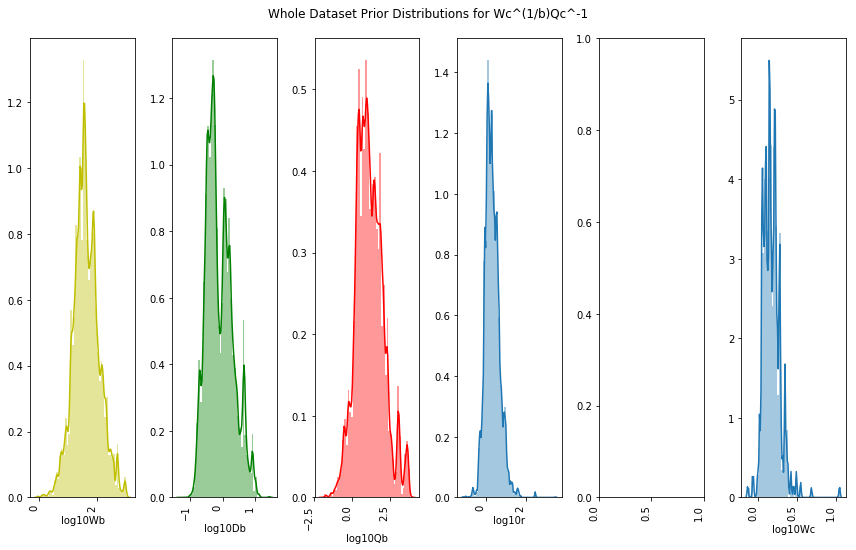

In [7]:
Hydroshortened['delta'] = 1 + (Hydroshortened['r']*(2/3)) + Hydroshortened['r']

Hydroshortened['log10A0'] = np.log10(Hydroshortened['A0'])
Hydroshortened['log10r'] = np.log10(Hydroshortened['r'])
Hydroshortened['log10n'] = np.log10(Hydroshortened['n'])
Hydroshortened['log10unitPower'] = np.log10(Hydroshortened['unitPower'])
Hydroshortened['log10De'] = np.log10(Hydroshortened['minEntrain'])

Hydroshortened['log10Wb'] = np.log10(Hydroshortened['bank_width'])
Hydroshortened['log10Db'] = np.log10(Hydroshortened['bank_depth'])
Hydroshortened['log10Qb'] = np.log10(Hydroshortened['bank_Q'])
Hydroshortened['log10De'] = np.log10(Hydroshortened['De'])
Hydroshortened['log10Wc'] = np.log10(np.exp(Hydroshortened['logWc']))

fig, axs = plt.subplots(ncols=6, figsize=(12, 8))
sns.distplot(Hydroshortened['log10Wb'], ax=axs[0], color='y')
sns.distplot(Hydroshortened['log10Db'], ax=axs[1], color='g')
sns.distplot(Hydroshortened['log10Qb'], ax=axs[2], color='r')
sns.distplot(Hydroshortened['log10r'], ax=axs[3])
sns.distplot(Hydroshortened['log10Wc'], ax=axs[5])

fig.suptitle("Whole Dataset Prior Distributions for Wc^(1/b)Qc^-1")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#save prior PDFs (no river type subsetting)
priorWb = Hydroshortened['log10Wb'].describe()
priorDb = Hydroshortened['log10Db'].describe()
prior_r = Hydroshortened['log10r'].describe()
priorDe = Hydroshortened['log10De'].describe()
priorQb = Hydroshortened['log10Qb'].describe()
priorWc = Hydroshortened['log10Wc'].describe()

Hydroshortened['log10a'] = np.log10(np.exp(Hydroshortened['loga']))
priorA = Hydroshortened['log10a'].describe()

priorWb.to_csv('priorsWb.csv')
priorDb.to_csv('priorsDb.csv')
prior_r.to_csv('priorsr.csv')
priorDe.to_csv('priorsDe.csv')
priorQb.to_csv('priorsQb.csv')
priorA.to_csv('priorsA.csv')
priorWc.to_csv('priorsWc.csv')

In [8]:
Hydroshortened['logchan_width'] = np.log10(Hydroshortened['chan_width'])

stdWdths = Hydroshortened.groupby('site_no')['logchan_width'].std().to_frame()
stdWdths = stdWdths.rename(columns={'logchan_width':'stdWdth'})
meanWdths = Hydroshortened.groupby('site_no')['logchan_width'].mean().to_frame()
meanWdths = meanWdths.rename(columns={'logchan_width':'meanWdths'})

Hydroshortened =  pd.merge(Hydroshortened, stdWdths, on='site_no')
Hydroshortened =  pd.merge(Hydroshortened, meanWdths, on='site_no')

In [9]:
#getting predictive models for variables
Hydroshortened['log10SLOPE'] = np.log10(Hydroshortened['SLOPE'])
forPriors = Hydroshortened.drop_duplicates('site_no') #make version with only one value per station

#Use forPriors b/c there should only be one value per station
resultB = sm.OLS(forPriors['b'], sm.add_constant(forPriors['stdWdth'])).fit()
resultA0 = sm.OLS(forPriors['log10A0'], sm.add_constant(forPriors[['meanWdths','stdWdth']])).fit()
resultWb = sm.OLS(forPriors['log10Wb'], sm.add_constant(forPriors[['meanWdths']])).fit()
resultDb = sm.OLS(forPriors['log10Db'], sm.add_constant(forPriors[['meanWdths', 'stdWdth']])).fit()
result_r = sm.OLS(forPriors['log10r'], sm.add_constant(forPriors[['meanWdths', 'stdWdth', 'b']])).fit()
resultQb = sm.OLS(forPriors['log10Qb'], sm.add_constant(forPriors[['meanWdths']])).fit()
result_a = sm.OLS(forPriors['log10a'], sm.add_constant(forPriors[['meanWdths', 'stdWdth']])).fit()
resultDe = sm.OLS(forPriors['log10De'], sm.add_constant(forPriors[['log10SLOPE']])).fit()

<h4><font color=darkolivegreen>Classification Space via KMeans: An Unsupervised Approach </font> </h4>
<p> K-Means is ran as an example of a wholy unsupervsied classification space.  I use the silhouette method to assess the ideal number of classes.  It is a measure of how close a point is to points in the other clusters in the predictor space, where values closer to 1 indicate the sample is far away from neighboring clusters.</p>

<h4> <font color=darkolivegreen>Classification Space via PCA + 'Fluvial Index' </font></h4>

In [10]:
#run PCA
features = ['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA']
x = Hydroshortened.loc[:, features].values # Separating out the features
y = Hydroshortened.loc[:,['site_no']].values # Separating out the target
x = StandardScaler().fit_transform(x) # normalizing the features

pca = PCA(n_components=5) #ran using 5 PCs
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = pca.components_
             , columns = ['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA'])

,chan_width,n,SLOPE,StreamOrde,DistDwnstrm,FCODEnorm,chan_depth,chan_velocity,unitPower,r,DASqKm,Fb,shearStress,minEntrain,TOTMA
0,0.004694,0.282052,0.441705,0.007752,0.014778,-0.059755,0.032224,-0.000392,0.464530,-0.001359,0.015391,-0.002555,0.501976,0.502365,0.007076
1,0.392868,-0.026784,-0.038576,0.459998,0.560254,0.060437,0.114457,0.038637,0.005728,-0.007825,0.547232,0.010742,-0.001397,0.000855,0.006755
2,-0.013496,-0.017223,0.005751,-0.014873,-0.020277,-0.007002,-0.006507,0.705733,0.005603,0.000390,-0.019265,0.707208,0.002341,0.002197,0.012237
3,0.144249,0.017498,-0.045405,0.042864,-0.118684,0.259523,0.458142,0.015268,0.031244,-0.003439,-0.136403,0.002665,-0.001959,0.021796,-0.814458
4,0.007205,0.079224,0.019416,-0.031969,-0.021754,0.458170,-0.014461,0.002771,-0.010519,0.873566,0.012387,-0.000164,0.003006,0.001745,0.135166


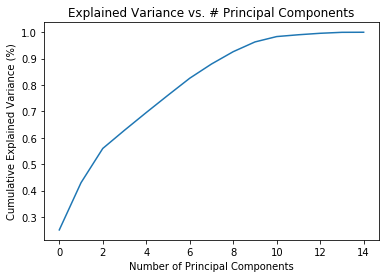

In [11]:
#Plot explained variance by each principal component 'PC'
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance vs. # Principal Components')

principalDf

<h1>UPDATE</h1>
<p>
    5 PCs were ultimately selected for analysis as they explain ~75% of variance in the dataset and are not too many to make developing intuitive understandings of the dataset difficult, particularly with only 12 initial variables before dimensionality reduction.
</p>
<p>
   The top weighted metrics for PC1 are unit power, slope, shear stress, and minimum entrained grain size.  For PC2 they are stream order, distance downstream, and drainage area.  For PC3 it is velocity and froude number,  for PC4 it is tidal influence, and PC5 is channel shape.
    <br><br>
    <b>The main axes of geomorphic variation across these rivers have thus been termed 'Sediment Transport', 'Longitunidal Location', 'Flow State', 'Tidal Influence', and 'Channel Shape'.</b>
</p>
<br>
<p>
    I then use a 'geomorphic index' which is just a sum of the top 5 PC values for each measurement.  This is purposefully not weighted by the relative importance of each PC (i.e. they're all weighted equally).  Then, classes are determined by breaking the measurements along the deciles for the distribution
</p>

In [12]:
#get quantiles for PCs and 'top-weighted' variables to assist in supervised classification
tertiles = [0.33, 0.66]
quantiles= [0.20, 0.40, 0.60, 0.80]
octiles = [0.125, 0.24, 0.365, 0.490, 0.615, 0.740, 0.865]

#add PC values to hydroshortened
Hydroshortened['PC1'] = principalComponents[:,0]
Hydroshortened['PC2'] = principalComponents[:,1]
Hydroshortened['PC3'] = principalComponents[:,2]
Hydroshortened['PC4'] = principalComponents[:,3]
Hydroshortened['PC5'] = principalComponents[:,4]

Hydroshortened['geomorphIndex'] = (Hydroshortened['PC1'])+(Hydroshortened['PC2'])+(Hydroshortened['PC3'])+(Hydroshortened['PC4'])+(Hydroshortened['PC5'])
geomorphIndex = np.quantile(Hydroshortened['geomorphIndex'], octiles)

Hydroshortened['clusterGeomorphIndex'] = np.where(Hydroshortened['geomorphIndex']<geomorphIndex[0], '1', 
                                               np.where(Hydroshortened['geomorphIndex']<geomorphIndex[1], '2', 
                                                       np.where(Hydroshortened['geomorphIndex']<geomorphIndex[2], '3', 
                                                               np.where(Hydroshortened['geomorphIndex']<geomorphIndex[3], '4',
                                                                        np.where(Hydroshortened['geomorphIndex']<geomorphIndex[4], '5', 
                                                                                 np.where(Hydroshortened['geomorphIndex']<geomorphIndex[5], '6', 
                                                                                          np.where(Hydroshortened['geomorphIndex']<geomorphIndex[6], '7','8')))))))
                                                                                                   #np.where(Hydroshortened['geomorphIndex']<geomorphIndex[7], '8',
                                                                                                    #       np.where(Hydroshortened['geomorphIndex']<geomorphIndex[8], '9', '10')))))))))

<h4> <font color=darkolivegreen>KMeans classes vs. Priors</font></h4>

<h4> <font color=darkolivegreen> PCA-based Classes vs. Priors</font></h4>

[(-2.5, -1)]

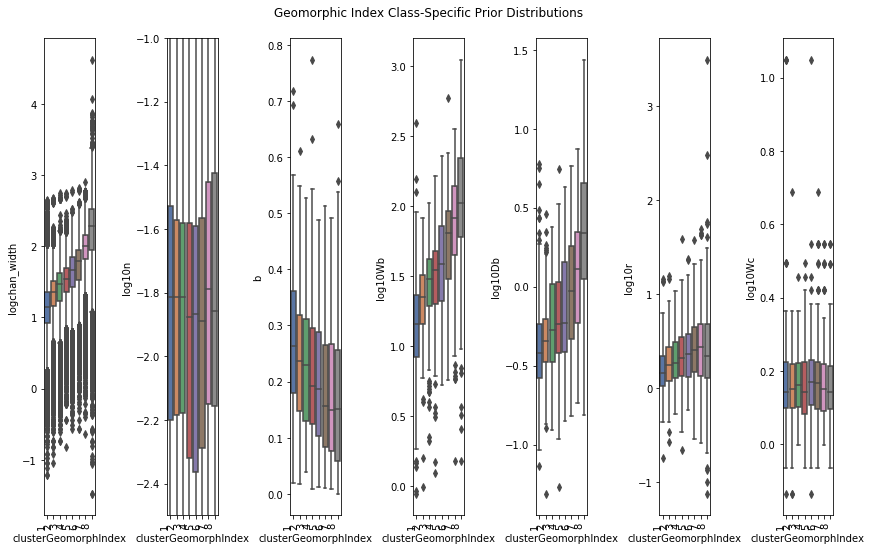

In [13]:
forPriors = Hydroshortened.drop_duplicates('site_no') #make version with only one value per station

fig, axs = plt.subplots(ncols=7, figsize=(12, 8))
sns.boxplot(x="clusterGeomorphIndex", y='logchan_width', data=Hydroshortened, palette='deep', ax=axs[0], order=['1', '2', '3', '4', '5', '6', '7', '8'])
sns.boxplot(x="clusterGeomorphIndex", y='log10n', data=Hydroshortened, palette='deep', ax=axs[1], order=['1', '2', '3', '4', '5', '6', '7', '8'])
sns.boxplot(x="clusterGeomorphIndex", y='b', data=forPriors, palette='deep', ax=axs[2], order=['1', '2', '3', '4', '5', '6', '7', '8'])
sns.boxplot(x="clusterGeomorphIndex", y='log10Wb', data=forPriors, palette='deep', ax=axs[3], order=['1', '2', '3', '4', '5', '6', '7', '8'])
sns.boxplot(x="clusterGeomorphIndex", y='log10Db', data=forPriors, palette='deep', ax=axs[4], order=['1', '2', '3', '4', '5', '6', '7', '8'])
sns.boxplot(x="clusterGeomorphIndex", y='log10r', data=forPriors, palette='deep', ax=axs[5], order=['1', '2', '3', '4', '5', '6', '7', '8'])
sns.boxplot(x="clusterGeomorphIndex", y='log10Wc', data=forPriors, palette='deep', ax=axs[6], order=['1', '2', '3', '4', '5', '6', '7', '8'])

fig.suptitle("Geomorphic Index Class-Specific Prior Distributions")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#axs[4].set(ylim=(-0.2, 0.2))
axs[1].set(ylim=(-2.5, -1))

<h4> <font color=darkolivegreen>Save subsetted parametric distributions by river type</font></h4>

In [14]:
#maps class to river based on 'clostest' median width of class and reach-averaged river width
logWidth = Hydroshortened.groupby('clusterGeomorphIndex')['logchan_width'].describe()
logWidth.to_csv('logWidthsbyClass.csv')

#save prior PDFs (no river type subsetting)
priorWbClass = Hydroshortened.groupby('clusterGeomorphIndex')['log10Wb'].describe()
priorDbClass = Hydroshortened.groupby('clusterGeomorphIndex')['log10Db'].describe()
prior_rClass = Hydroshortened.groupby('clusterGeomorphIndex')['log10r'].describe()
priorA0Class = Hydroshortened.groupby('clusterGeomorphIndex')['log10A0'].describe()
priorNClass = Hydroshortened.groupby('clusterGeomorphIndex')['log10n'].describe()
priorBClass = Hydroshortened.groupby('clusterGeomorphIndex')['b'].describe()

Hydroshortened['log10a'] = np.log10(np.exp(Hydroshortened['loga']))
priorAClass = Hydroshortened.groupby('clusterGeomorphIndex')['log10a'].describe()

priorWbClass.to_csv('priorsWbClass.csv')
priorDbClass.to_csv('priorsDbClass.csv')
prior_rClass.to_csv('priorsRClass.csv')
priorAClass.to_csv('priorsAClass.csv')
priorA0Class.to_csv('priorsA0Class.csv')
priorNClass.to_csv('priorsNClass.csv')
priorBClass.to_csv('priorsBClass.csv')

<h2><font color=darkcyan> Analysis Using MERIT Hydro- NOT RUNNING </font></h2>

<h2><font color=darkcyan> Compare Classifications Using NHD v2.1 and MERIT Hydro </font></h2>

<h1>R classification space for CT HRT model </h1>